# Regularized Linear Regression and Bias vs Variance

## Introduction

In this exercise, I will implement regularized linear regression and use it to study models with different bias-variance properties. 



I will import all libraries required for this programming exercise. I will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. Instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [330]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

<a id="section1"></a>
## 1 Regularized Linear Regression

In the first half of the exercise, a regularized linear regression is implemented to predict the amount of water flowing out of a dam using the change of water level in a reservoir. Later in this notebook I will examine the effects of bias v.s.
variance. 

### 1.1 Visualizing the dataset

We begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$. This dataset is divided into three parts:

- A **training** set that your model will learn on: `X`, `y`
- A **cross validation** set for determining the regularization parameter: `Xval`, `yval`
- A **test** set for evaluating performance. These are “unseen” examples which your model did not see during training: `Xtest`, `ytest`



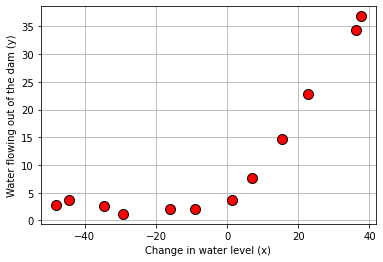

In [331]:
# Load from ex5data1.mat, where all variables will be store in a dictionary
data = loadmat(os.path.join('Data', 'ex5data1.mat'))

# Extract train, test, validation data from dictionary
# and also convert y's form 2-D matrix (MATLAB format) to a numpy vector
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Number of examples
m = y.size

# Plot training data
pyplot.grid()
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)');

test_X = np.concatenate([np.ones((m, 1)), X],axis =1)

### 1.2 Regularized linear regression cost function

Recall that regularized linear regression has the following cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize
the $\theta_0$ term.


<a id="linearRegCostFunction"></a>

<a id="section2"></a>
### 1.3 Regularized linear regression gradient

Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$


In [3]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):

    # Initialize some useful values
    m = y.size # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    h = np.dot(X,theta)
    difference = h-y 
    difference_squared_total = np.sum(difference**2)
    reg_term_1 = difference_squared_total/ (2*m)
    
    theta_reg_squared_total = np.sum(theta[1:,] * theta[1:,])
    reg_term_2 = theta_reg_squared_total * (lambda_ / (2 *m)) # multiplying reg term by lambda over 2m
    J= reg_term_1 + reg_term_2
    """
    Computing the gradients below
    """
    for i in range(grad.shape[0]):
        if i==0:
            grad[i] = np.sum(difference)/m 
        grad[i] = (np.sum(difference * X[:,i])/m) + ((lambda_ / m ) * theta[i])
            


    return J, grad

In [333]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192)\n' % J)

Cost at theta = [1, 1]:	   303.993192 
This value should be about 303.993192)



In [334]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Gradient at theta = [1, 1]:  [-15.219682, 598.250744] 
 (this value should be about [-15.303016, 598.250744])



### Fitting linear regression

the next cell will run the code in `trainLinearReg` (found in the module `utils.py`) to compute the optimal values of $\theta$. This training function uses `scipy`'s optimization module to minimize the cost function.

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, I will be using polynomial regression with regularization.

Finally, the code in the next cell should also plot the best fit line.

 While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, I will implement a function to generate learning curves that can help you debug my learning algorithms even if it is not easy to visualize the
data.

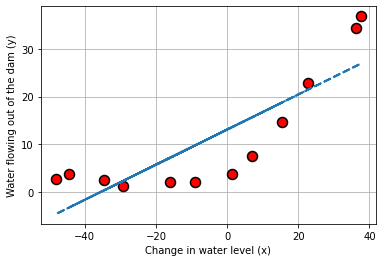

In [335]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = utils.trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)
#  Plot fit over the data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);
pyplot.grid()

<a id="section3"></a>
## 2 Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

I will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning Curves

 Recall that a learning curve plots training and cross validation error as a function of training set size. The next cell returns a vector of errors for the training set and cross validation set.

plotting the learning curve from the training and cross validation set error for different training set sizes. I will use different subsets of the original training set `X`. 

I will use the `trainLinearReg` function (by calling `utils.trainLinearReg(...)`) to find the $\theta$ parameters. Note that the `lambda_` is passed as a parameter to the `learningCurve` function.
After learning the $\theta$ parameters, compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$

Note that the training error does not include the regularization term. One way to compute the training error is to use my existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. <font color='red'><b>Note to self - for the cross validation error, you should compute it over the entire cross validation set.</font></b> 

<a id="func2"></a>

In [1]:
def learningCurve(X, y, Xval, yval, lambda_=0):

    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    for i in range(1,m+1):
        m = i 
        theta = utils.trainLinearReg(linearRegCostFunction, X[:i,:], y[:i], lambda_=0) # find optimal values of
    #theta for train set 
        h = np.dot(X[:i,:],theta)
        difference = h - y[:i]
        error_train[i-1] = (1/ (2 *m )) * np.sum(difference**2)
        
        theta = utils.trainLinearReg(linearRegCostFunction, Xval[:i,:], yval[:i], lambda_=0)
        h = np.dot(Xval[:,:],theta)
        difference = h - yval[:]
        error_val[i-1] = (1/ (2 *(yval.size))) * np.sum(difference**2)
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	253.098982
  	2		0.000000	139.727487
  	3		3.286595	49.773898
  	4		2.842678	30.855158
  	5		13.154049	31.887001
  	6		19.443963	32.668299
  	7		20.098522	29.377233
  	8		18.172859	29.297406
  	9		22.609405	28.953669
  	10		23.261462	28.956963
  	11		24.317250	28.824951
  	12		22.373906	29.050121


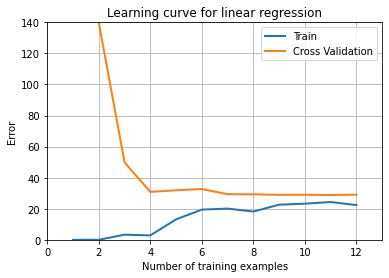

In [337]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.grid()
pyplot.axis([0, 13, 0, 140])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

<a id="section4"></a>

## 3 Polynomial regression

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

I will add more features using the higher powers of the existing feature $x$ in the dataset below.

<a id="polyFeatures"></a>

In [2]:
def polyFeatures(X, p):

    X_poly = np.zeros((X.shape[0], p))
    
    for i in range(p):
        test =  X[:,0]**(i+1)
        X_poly[:,i] = test
        
    

    return X_poly

The next cell will apply it to the training set, the test set, and the cross validation set.

In [407]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = utils.featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

## 3.1 Learning Polynomial Regression

Training polynomial regression using the linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. 

I wil be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$). I have normalised the data to avoid this

Before learning the parameters $\theta$ for the polynomial regression, use `featureNormalize` and normalize the features of the training set, storing the mu, sigma parameters separately. 

After learning the parameters $\theta$, you should see two plots generated for polynomial regression with $\lambda = 0$, which should be similar to the ones here:

<table>
    <tr>
        <td><img src="Figures/polynomial_regression.png"></td>
        <td><img src="Figures/polynomial_learning_curve.png"></td>
    </tr>
</table>

the polynomial fit is able to follow the datapoints very well, thus, obtaining a low training error. The figure on the right shows that the training error essentially stays zero for all numbers of training samples. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

The learning curve  shows the same effect where the training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	162.401555
  	2		0.000000	166.615410
  	3		0.000000	68.037558
  	4		0.000000	12.521619
  	5		0.000000	46.473034
  	6		0.000000	47.025035
  	7		0.000000	49.117744
  	8		0.000006	121.719972
  	9		0.000234	87.265108
  	10		0.034300	164.900898
  	11		0.035282	1342.419585
  	12		0.029970	77.606054


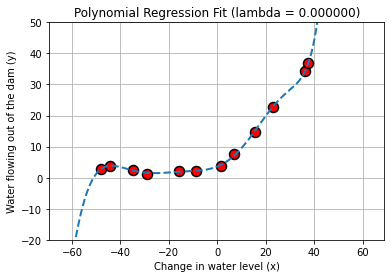

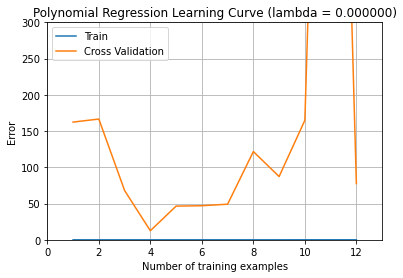

In [409]:
lambda_ = 0
theta = utils.trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=1000)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.grid()
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.grid()
pyplot.axis([0, 13, 0, 300])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))